### Recommender Systems

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

Downloading and describing the dataset

In [12]:
cols = ['user_id', 'item_id', 'rating', 'timestamp']
item_cols = ['item_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 
             'Animation','Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
            'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
ratings =  pd.read_csv('ml-100k/u.data', sep='\t', names=cols)
items = pd.read_csv('ml-100k/u.item', sep='|', names=item_cols, encoding = 'latin-1')
#ratings_base = pd.read_csv('ml-100k/ua.base', sep='\t', names=cols)
#ratings_test = pd.read_csv('ml-100k/ua.test', sep='\t', names=cols)


ratings.describe()

n_users_base = ratings['user_id'].unique().max()
n_items_base = ratings['item_id'].unique().max()

n_users_base,n_items_base

(943, 1682)

<function matplotlib.pyplot.show(*args, **kw)>

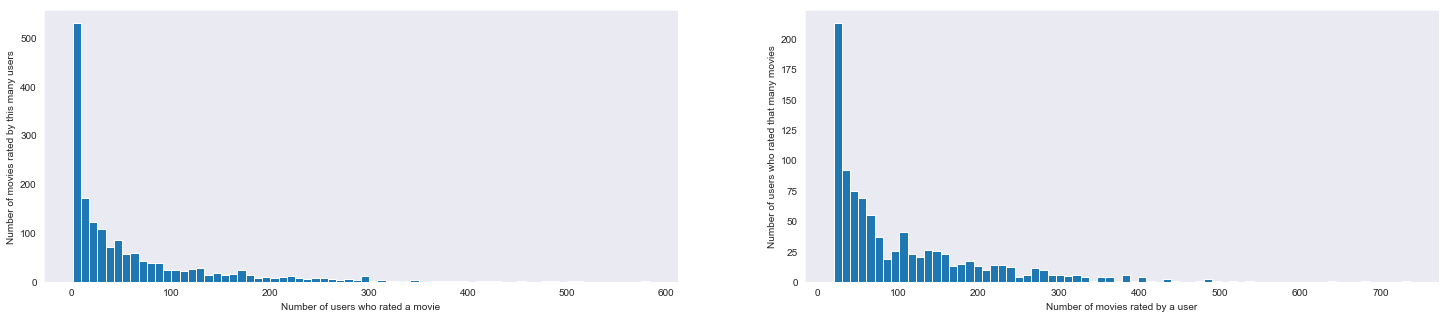

In [13]:
fig, axes = plt.subplots(1,2, figsize=(25, 5))
#plt.figure(figsize=(12,8))
axes[0].hist(ratings.groupby("item_id").count()["user_id"], bins=70)
axes[1].hist(ratings.groupby("user_id").count()["item_id"], bins=70,)
axes[0].set_xlabel('Number of users who rated a movie')
axes[0].set_ylabel('Number of movies rated by this many users')
axes[1].set_xlabel("Number of movies rated by a user")
axes[1].set_ylabel("Number of users who rated that many movies")
plt.show

#### The first plot describes the probability distribution of the number of users who rated a movie. The maximum number of movies is rated by only a small proportion of the users. 

#### The second plot describes the probability distribution of the number of movies rated by certain number of users. We can see that a very small proportion of movies are rated by the maximum number of users which is also very small compared to the actual number of users (942). A decreasing number of users have rated more than 100 movies.

#### Both plots essentially provide the same information, that the user-item matrix is very sparse.

In [15]:
# creating the user-item matrix from the given data

user_item = ratings.pivot_table(index="user_id",columns="item_id",values='rating')



# Calculating the average number of null entries for each user
avg_null = 0
for i in range(n_users_base):
    avg_null += pd.isnull(user_item.iloc[i][:]).sum()   
    
avg_null = avg_null/n_users_base
print("Average number of null entries per user: ", avg_null)
# As it can be seen, a huge proportion of entries on average are null for each user

Average number of null entries per user:  1575.9554612937434


#### Which again only tells us that most of the user-item matrix is empty


#### User-User method

In [16]:
user_item = ratings.pivot_table(index="user_id",columns="item_id",values='rating')

# Transposing user-item matrix before finding correlation since pandas correlation function works on columns 
# and we need user-user correlation
user_item_trans = user_item.T

user_user_corr = user_item_trans.corr(method = 'pearson')

# normalising ratings by subtracting the users average rating for items he has rated
user_item_norm = user_item.sub(user_item.mean(axis=1), axis=0)

# Since a user will always be correlated with himself, setting this correlation as 0 
# so that the user himself is not counted as a closest neighbour
np.fill_diagonal(user_user_corr.values, 0)

# sorting to get 10 closest neighbours
sorted_indices = np.argsort(user_user_corr.values, axis = 1)+1

In [17]:
#Function to give a mapping of 10 closest user to every user
def get_neighbours_user(user_user_corr, sorted_indices):
    user_neighbours = []
    for i in range(len(user_user_corr)):
        user_neighbours.append(user_user_corr.iloc[i][sorted_indices[i]].dropna()[-10:].index.values)
    return user_neighbours


# Function to get ratings of movies rated by the active users nearest neighbours but not rated by the active user
def nearest_movie_ratings_user(empty_rating_indices, user_item_matrix, user_neighbours, active_user):
        
    t = user_item_matrix.loc[user_neighbours[active_user-1], empty_rating_indices]
    
    return t
#Function to get active users nearest neighbour weights
def nearest_user_weights_user(empty_rating_indices, user_user_corr, user_neighbours, active_user):
    
    
    y = np.array(user_user_corr.loc[active_user, user_neighbours[active_user-1]])
    
    w = pd.DataFrame(data  = y, index = user_neighbours[active_user-1])
    w = pd.concat([w] * (len(empty_rating_indices)), axis=1, ignore_index=True)
    w.columns = empty_rating_indices

    return w

# Function to calculate predicted rating and give recommendations
def get_recommendations_user(w, q, empty_rating_indices, items, active_user, user_item):
    
    
    aumr = np.nanmean(user_item.loc[active_user])
    A = w*q
    mask = (A).isnull()

    sum_weights = np.nansum(w.mask(mask, np.nan), axis = 0)
  
    sum_weights[sum_weights == 0] = np.nan
    ratings = pd.Series(np.nansum(A, axis = 0)/sum_weights, index = empty_rating_indices)
    ratings = ratings.dropna()
    top_ten = ratings.sort_values()[-10:]+aumr
    x = pd.DataFrame(items.loc[items['item_id'].isin(top_ten.index)][['item_id','movie_title']]).join(pd.Series(top_ten, name = 'rating'), on = 'item_id')
    return x

In [ ]:
# Getting a mapping of top ten neighbours for all users in the data

user_neighbours = get_neighbours_user(user_user_corr, sorted_indices)

result = dict()
#change range parameters for full list of users. Set to 50 because algorithm takes time to execute
for active_user in range(1,51):
    # Getting a list of items that have not been rated by active user
    empty_rating_indices = user_item.loc[active_user].index[user_item.loc[active_user].isnull()]

    # Getting ratings of all the items that have not been rated by the user but have been rated by his nearest neighbours
    r = nearest_movie_ratings_user(empty_rating_indices, user_item_norm, user_neighbours, active_user)
    # Getting weights of nearest neighbours
    s = nearest_user_weights_user(empty_rating_indices, user_user_corr, user_neighbours, active_user)


    # Calculating predicted rating and giving recomendations
    recs = get_recommendations_user(s, r, empty_rating_indices, items, active_user, user_item)

    # Appending to result dictionary
    result[active_user] = recs[['movie_title', 'rating']].values.tolist()

#Uncomment to see result

#print(result)

In [ ]:
# Writing file
with open('pred_user_user.txt', 'w') as file:
    for key, value in result.items():
        file.write('{{User {}:{}}}\n'.format(key, value))

#### Item-Item method

In [18]:
##item-item method

item_item_corr = user_item.corr(method = 'pearson')
# Since a item will always be correlated with itself, setting this correlation as 0 
# so that the item itself is not counted as a closest neighbour
np.fill_diagonal(item_item_corr.values, 0)
sorted_indices = np.argsort(item_item_corr.values, axis = 1)+1

In [19]:
#Function to give a mapping of 10 closest items to every item

def get_neighbours_item(item_item_corr, sorted_indices):
    item_neighbours = []
    for i in range(len(item_item_corr)):
        item_neighbours.append(item_item_corr.iloc[i][sorted_indices[i]].dropna()[-10:].index.values)
    return item_neighbours

# Function to get ratings of movies nearest to unrated movies of active user

def nearest_movie_ratings_item(empty_rating_indices, user_item_matrix, item_neighbours, active_user):
    
    q = pd.DataFrame(index = empty_rating_indices, columns= range(10))

    for x in q.index:
        #print('x: ', x, user_item.loc[active_user , item_neighbours[x-1]])
        y = np.array(user_item_matrix.loc[active_user, item_neighbours[x-1]])
        if len(y)<10:
            y = np.pad(y, (0, 10-len(y)), 'constant', constant_values=(np.nan,))
        q.loc[x] = np.array(y)
    return q

# Function to get the weights of the movies nearest to unrated movies of active user

def nearest_movie_weights_item(empty_rating_indices, item_item_corr, item_neighbours, active_user):
    w = pd.DataFrame(index = empty_rating_indices, columns= range(10))

    for x in w.index:
        #print('x: ', x, user_item.loc[active_user , item_neighbours[x-1]])
        y = np.array(item_item_corr.loc[x, item_neighbours[x-1]])
        if len(y)<10:
            y = np.pad(y, (0, 10-len(y)), 'constant', constant_values=(np.nan,))
        w.loc[x] = np.array(y)
    return w

# Function to predict rating and give recommendations
def get_recommendations_item(w, q, empty_rating_indices, items):
    
    A = w*q
    #print(A)
    mask = (A).isnull()
    sum_weights = np.nansum(w.mask(mask, np.nan), axis = 1)
    sum_weights[sum_weights == 0] = np.nan
    ratings = pd.Series(np.nansum(A, axis = 1)/sum_weights, index = empty_rating_indices)
    ratings = ratings.dropna()
    top_ten = ratings.sort_values()[-10:]
    x = pd.DataFrame(items.loc[items['item_id'].isin(top_ten.index)][['item_id','movie_title']]).join(pd.Series(top_ten, name = 'rating'), on = 'item_id')
    return x

In [21]:
result = dict()

#getting a mapping of the nearest neighbours to all items
item_neighbours = get_neighbours_item(item_item_corr, sorted_indices)

#Since the alogorithm was taking time to run, I only calculated for first 50 users
for active_user in range(1,51):

    
    # Finding all items for which active user has no rating
    empty_rating_indices = user_item.loc[active_user].index[user_item.loc[active_user].isnull()]


    #print(pd.DataFrame([item_neighbours[i-1] for i in empty_rating_indices.values], index = empty_rating_indices))
    #print(user_item.loc[active_user][item_neighbours[empty_rating_indices.values[1]-1]])
    #print(item_item_corr.loc[2][item_neighbours[1]])

    
    r = nearest_movie_ratings_item(empty_rating_indices, user_item, item_neighbours, active_user)
    s = nearest_movie_weights_item(empty_rating_indices, item_item_corr, item_neighbours, active_user)

    recs = get_recommendations_item(s, r, empty_rating_indices, items)
    result[active_user] = recs[['movie_title', 'rating']].values.tolist()

#Uncomment to print result
#print(result)

In [ ]:
# Writing file
with open('pred_item_item.txt', 'w') as file:
    for key, value in result.items():
        file.write('{{User {}:{}}}\n'.format(key, value))

#### Content Based Recommendation

In [22]:
tmdb = pd.read_csv('TMDB/tmdb_5000_movies.csv')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


In [23]:
df = tmdb[['title', 'overview']]
tfidf = TfidfVectorizer(stop_words='english')
df['overview'].isna().sum()

df['overview'].count()

df['overview'] = df['overview'].fillna('')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [24]:
#get tf-idf matrix for overview
tfidf_matrix_overview= tfidf.fit_transform(df['overview'])

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix_overview, tfidf_matrix_overview)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


In [25]:
movie_indices = pd.Series(df.index, index = df['title'])
movie_indices

title
Avatar                                         0
Pirates of the Caribbean: At World's End       1
Spectre                                        2
The Dark Knight Rises                          3
John Carter                                    4
                                            ... 
El Mariachi                                 4798
Newlyweds                                   4799
Signed, Sealed, Delivered                   4800
Shanghai Calling                            4801
My Date with Drew                           4802
Length: 4803, dtype: int64

In [26]:
def get_items(query, cosine_sim = cosine_sim):

    # We check if query is present in database
    # If it is present we directly get that data point, and get movies similar to that query 
    # using overview cosine similarity
    if query in df['title'].unique():
        query_index = movie_indices[query]
        
        sim_to_query = np.flip(np.argsort(cosine_sim[query_index]))[0]
        #print(sim_to_query.shape)

    # If query is not present in datbase, we look for closest matching titles in database
    else:
        
        df_title_aug = df['title'].append(pd.Series([query]), ignore_index = True)
        
        # Finding closest matching titles
        tfidf_matrix_title = tfidf.fit_transform(df_title_aug)

        cosine_sim_title = linear_kernel(tfidf_matrix_title, tfidf_matrix_title)

        title_indices = pd.Series(df_title_aug.index, index = df_title_aug) 

        title_closest_to_query = np.flip(np.argsort(cosine_sim_title[title_indices[query]]))[1]


        # Use the closest matching title and get movies similar to that title
        sim_to_query = np.flip(np.argsort(cosine_sim[title_closest_to_query]))
    
    top_ten = sim_to_query[1:11]
    #print(top_ten)
    return df['title'].iloc[top_ten]

In [27]:
get_items('avatar')

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title, dtype: object

In [28]:
get_items('superman')

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


870                          Superman II
10                      Superman Returns
2433    Superman IV: The Quest for Peace
914                 Central Intelligence
4659                          Horse Camp
2527         National Lampoon's Vacation
3542                                R100
45                           World War Z
1368                      Identity Thief
1237                  The Out-of-Towners
Name: title, dtype: object

In [29]:
get_items('narnia')

/usr/local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


63      The Chronicles of Narnia: The Lion, the Witch ...
109     The Chronicles of Narnia: The Voyage of the Da...
2122                                           Epic Movie
942                                      The Book of Life
494                                         The Lion King
106                                       Shrek the Third
1790                           O Brother, Where Art Thou?
2796                                The Prisoner of Zenda
38                               The Amazing Spider-Man 2
3986                                     The Wizard of Oz
Name: title, dtype: object